# M3 Process MERFISH

## Perpose

QC and annotate MERFISH data from mouse M3

## Setup

In [ ]:
from pathlib import Path

import anndata as ad
import hotspot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import scanpy as sc
import scipy as sp
import scvi
import seaborn as sns
import squidpy as sq

np.random.seed(42)

base_path, data_path, plots_path, results_path = petracer.config.get_paths("tumor_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Load data

In [9]:
samples = {"F320-3-2":Path("/lab/weissman_imaging/4T1/241028_F320-3-2_MF4+"),
           "F320-3-4": Path("/lab/weissman_imaging/4T1/241103_F320-3-4_MF4++"),
           "F320-3-3": Path("/lab/weissman_imaging/4T1/241220-F320-3-3-MF4++"),
           "F320-4-3": Path("/lab/weissman_imaging/4T1/241213_F320-4-3_MF4++")
          }
sample_names = {"F320-3-2": "M3-1",
                "F320-3-4": "M3-2",
                "F320-3-3": "M3-3",
                "F320-4-3": "M3-4"}

In [10]:
adata = []
nuclei = []
for sample, path in samples.items():
    sample_name = sample_names[sample]
    counts = pd.read_csv(path / "proseg_counts.csv",index_col=0)
    counts.index = counts.index.astype(int)
    cell_meta = pd.read_csv(path / "polygons_metadata.csv").assign(sample=sample_name)
    cell_meta.index = cell_meta["cell"].values
    idx = cell_meta.index.intersection(counts.index)
    cell_meta = cell_meta.loc[idx]
    counts = counts.loc[idx]
    sample_adata = ad.AnnData(counts, obs=cell_meta)
    sample_adata.obs["cellBC"] = (sample_name + "-" + sample_adata.obs["cell"].astype(str))
    sample_adata.obs_names = sample_adata.obs["cellBC"].values
    if sample == "F320-3-4":
        sample_adata = sample_adata[sample_adata.obs['fov'] != 19].copy()
    adata.append(sample_adata)
adata = ad.concat(adata, join='outer', fill_value=0)
adata.obs["sample"] = pd.Categorical(adata.obs["sample"], categories=sample_names.values())
adata.obsm["spatial"] = adata.obs[["centroid_x", "centroid_y"]].values

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Quality control

In [13]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)

Remove cells with too few transcripts or genes detected

filtering 41764 cells out of 208259


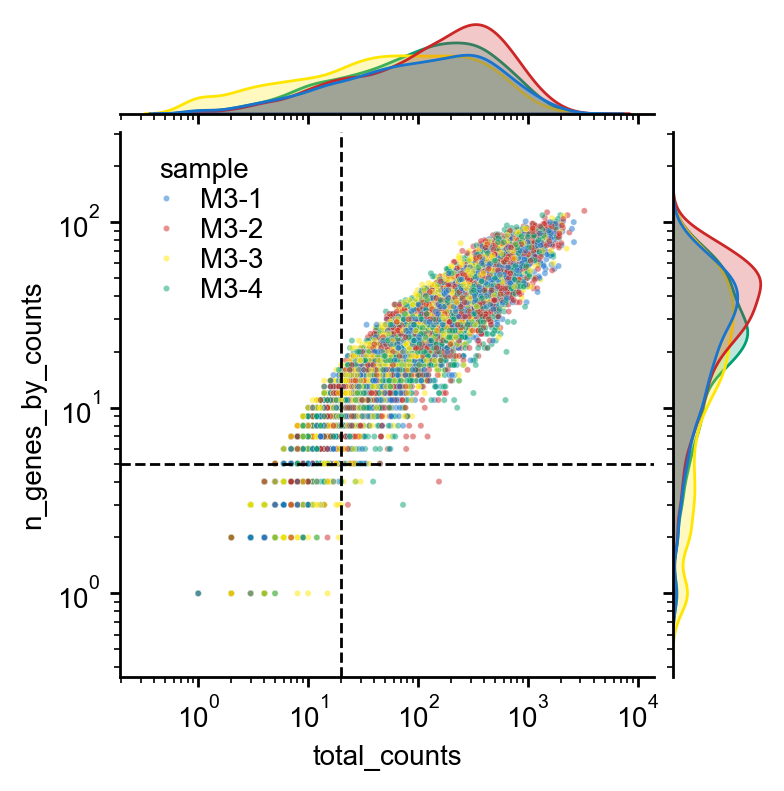

In [14]:
adata.obs["keep"] = True
adata.obs.loc[(adata.obs["total_counts"] < 1), "keep"] = False
min_genes = 5
min_counts = 20
sns.jointplot(data=adata.obs.query("keep").sample(10000),x="total_counts",y="n_genes_by_counts",kind="scatter",s=5, alpha=0.5,marginal_kws=dict(log_scale=True),height=4, hue="sample")
plt.axhline(min_genes, color='black', linestyle='dashed', linewidth=1)
plt.axvline(min_counts, color='black', linestyle='dashed', linewidth=1)
adata.obs.loc[(adata.obs["n_genes_by_counts"] < min_genes) | (adata.obs["total_counts"] < min_counts), "keep"] = False
print("filtering", len(adata.obs[~adata.obs["keep"]]), "cells", "out of", len(adata.obs))

Cells passing QC by sample

/tmp/ipykernel_909340/4120225999.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["sample","keep"]).size().unstack().fillna(0).plot(kind="bar", stacked=True)


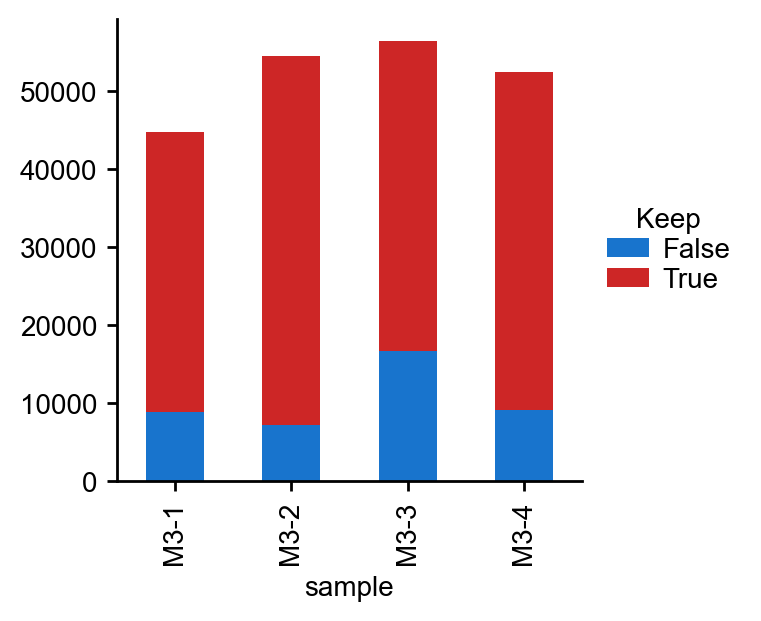

In [15]:
adata.obs.groupby(["sample","keep"]).size().unstack().fillna(0).plot(kind="bar", stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Keep")

In [16]:
adata = adata[adata.obs["keep"]].copy()

## Normalize and scale

In [17]:
adata.layers["counts"] = sp.sparse.csr_matrix(adata.X.copy())
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=2e2)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X.copy()
sc.pp.regress_out(adata, ["total_counts"])
sc.pp.scale(adata)
adata.layers["scaled"] = adata.X.copy()

## resolVI

In [ ]:
adata.obs['predicted_celltype'] = 'unknown'
adata.obsm["X_spatial"] = adata.obsm["spatial"]
query_resolvi = scvi.external.RESOLVI.load_query_data(
    reference_model = "data/MF4plusplus_resolviModel/"
    , adata=adata)

INFO     File data/MF4plusplus_resolviModel/model.pt already downloaded                                            


/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lab/solexa_weissman/kyost/miniconda3/envs/petracer/ ...
  rank_zero_warn(
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/model/base/_utils.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed d

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

2025-01-02 13:40:20 - Guessed max_plate_nesting = 2


Epoch 1/50:   2%|▏         | 1/50 [00:01<01:10,  1.43s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/50:   2%|▏         | 1/50 [00:01<01:12,  1.47s/it, v_num=1]


In [20]:
adata.obsm["resolvi_celltypes"] = query_resolvi.predict(adata, num_samples=3, soft=True)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lab/solexa_weissman/kyost/miniconda3/envs/petracer/ ...
  rank_zero_warn(
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/_utils.py:240: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[_constants._SCVI_UUID_KEY] = str(uuid4())
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:226: UserWarning: Category 46583 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Sampling variables, sample: 100%|██████████| 333/333 [01:08<00:00,  4.85it/s]


In [21]:
resolvi_celltypes = adata.obsm["resolvi_celltypes"]
adata.obs["resolvi_predicted"] = resolvi_celltypes[resolvi_celltypes > 0.5].idxmax(axis=1)
adata.obsm["X_resolVI"] = query_resolvi.get_latent_representation(adata)

/tmp/ipykernel_909340/802170199.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs["resolvi_predicted"] = resolvi_celltypes[resolvi_celltypes > 0.5].idxmax(axis=1)
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lab/solexa_weissman/kyost/miniconda3/envs/petracer/ ...
  rank_zero_warn(


Generate resolVI UMAP

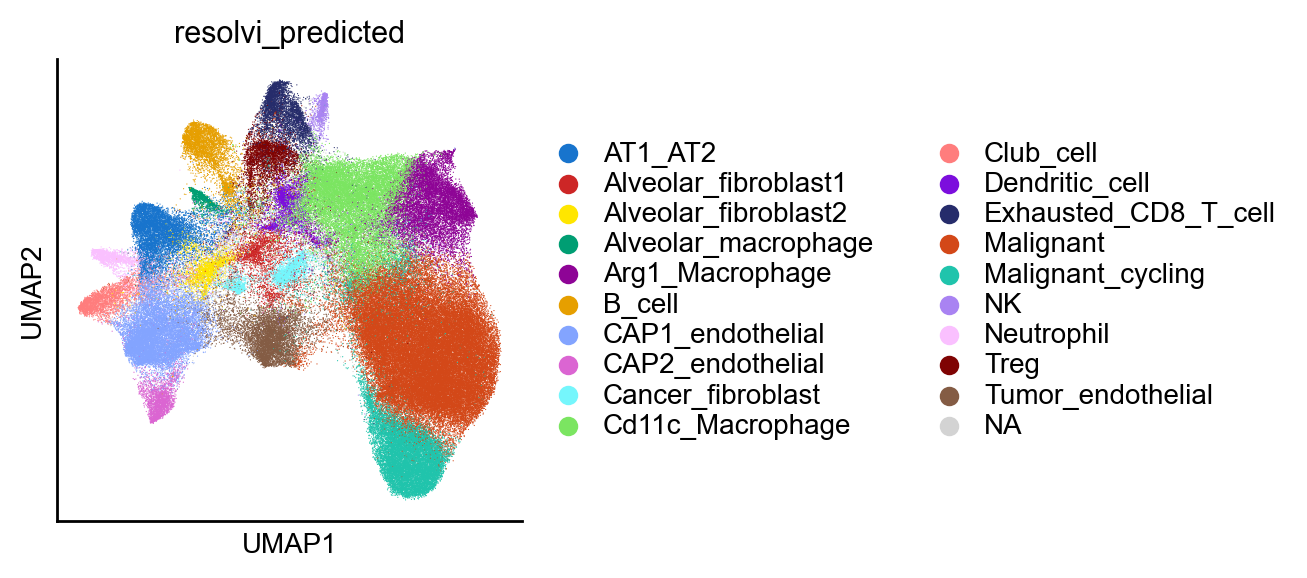

In [ ]:
sc.pp.neighbors(adata, use_rep="X_resolVI")
sc.tl.umap(adata,min_dist=.2)
sc.pl.umap(adata, color=['resolvi_predicted'])

Calculate background proportions

In [24]:
sample_mixtures = query_resolvi.sample_posterior_predictive(
    model=query_resolvi.module.model_residuals,
    return_sites=[
        'mixture_proportions'
        ],
    summary_fun={"post_sample_means": np.mean},
    num_samples=3, batch_steps=30)
sample_mixtures = pd.DataFrame(sample_mixtures).T

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lab/solexa_weissman/kyost/miniconda3/envs/petracer/ ...
  rank_zero_warn(
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/_utils.py:240: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[_constants._SCVI_UUID_KEY] = str(uuid4())
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:226: UserWarning: Category 46583 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Sampling variables, sample: 100%|██████████| 1301/1301 [02:30<00:00,  8.64it/s]


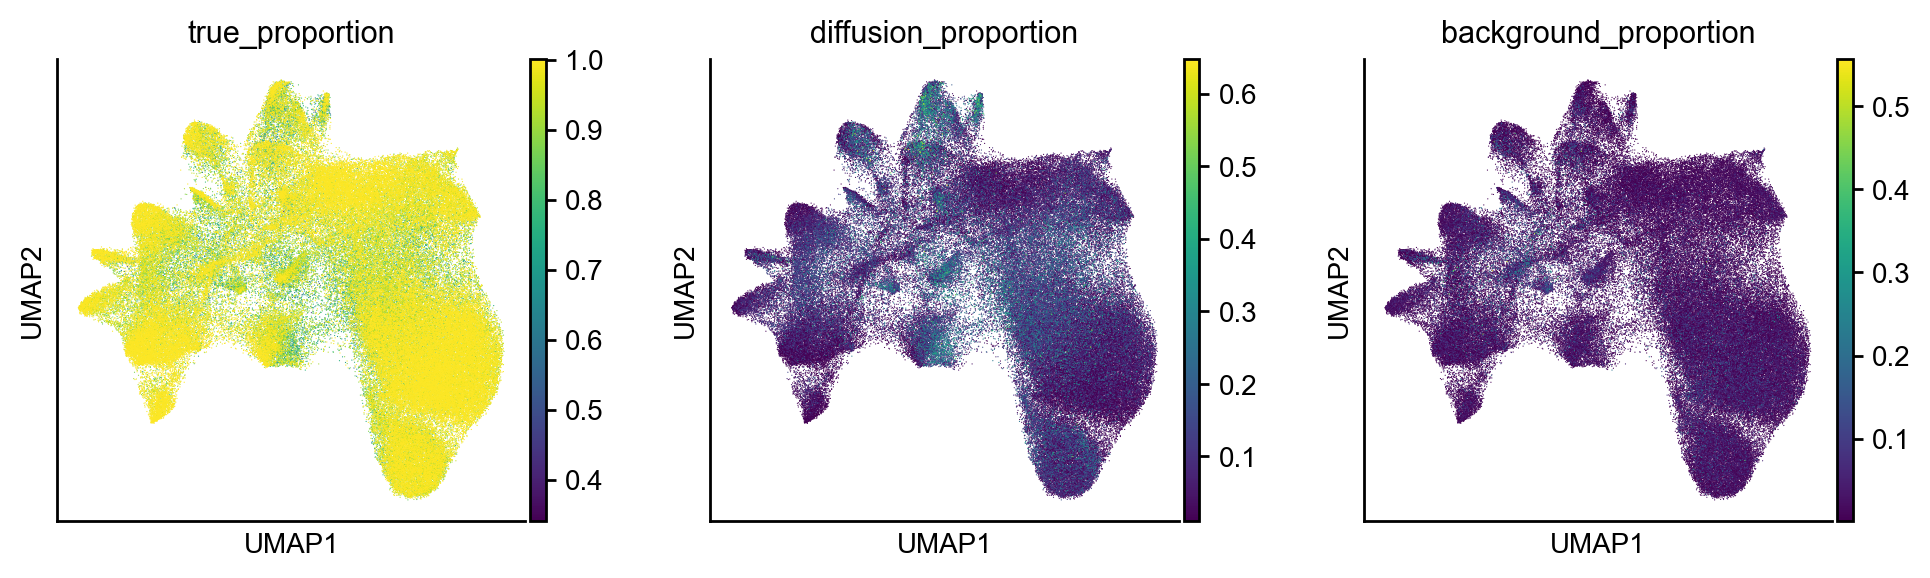

In [ ]:
adata.obs[['true_proportion', 'diffusion_proportion', 'background_proportion']] = sample_mixtures.loc['post_sample_post_sample_means', 'mixture_proportions']
sc.pl.umap(adata, color=[ 'true_proportion', 'diffusion_proportion', 'background_proportion'])

Remove cells with high background proportion

In [27]:
adata.obs['keep'] = True
min_proportion = 0.8
adata.obs.loc[(adata.obs["true_proportion"] < min_proportion) | 
    (adata.obs.resolvi_predicted.isna()), "keep"] = False
print("filtering", len(adata.obs[~adata.obs["keep"]]), "cells", "out of", len(adata.obs))

filtering 20508 cells out of 166495


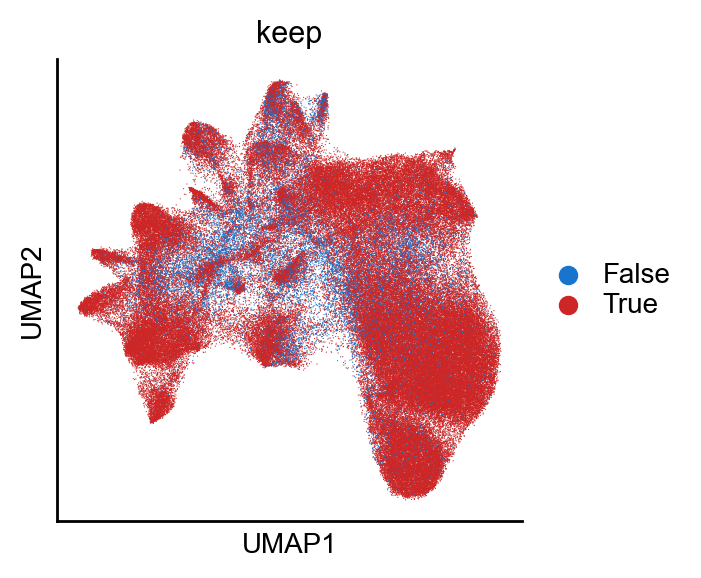

In [28]:
sc.pl.umap(adata, color=[ 'keep'])

Generate corrected counts

In [29]:
samples_corr = query_resolvi.sample_posterior_predictive(
    model=query_resolvi.module.model_corrected,
    return_sites=['px_rate'],
    summary_fun={"post_sample_q5": lambda x, axis: np.quantile(x, 0.05, axis=axis)},
    num_samples=20, batch_steps=30)
samples_corr = pd.DataFrame(samples_corr).T

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lab/solexa_weissman/kyost/miniconda3/envs/petracer/ ...
  rank_zero_warn(
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/_utils.py:240: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[_constants._SCVI_UUID_KEY] = str(uuid4())
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:226: UserWarning: Category 46583 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Sampling variables, sample: 100%|██████████| 1301/1301 [12:08<00:00,  1.79it/s]


In [30]:
mat = np.nan_to_num(samples_corr.loc['post_sample_post_sample_q5', 'px_rate'])
mat[mat < 0] = 0
adata.layers['generated_expression'] = mat

Regenerate resolVI UMAP

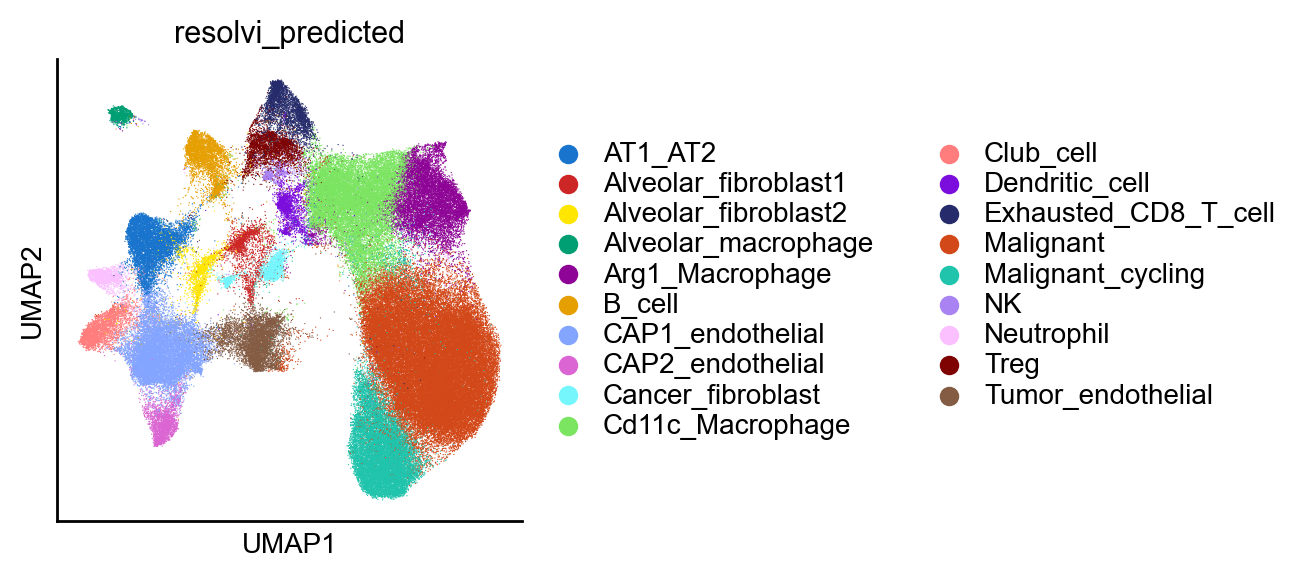

In [ ]:
adata = adata[adata.obs.keep].copy()
sc.pp.neighbors(adata, use_rep="X_resolVI")
sc.tl.umap(adata,min_dist=.2)
sc.pl.umap(adata, color=['resolvi_predicted'])

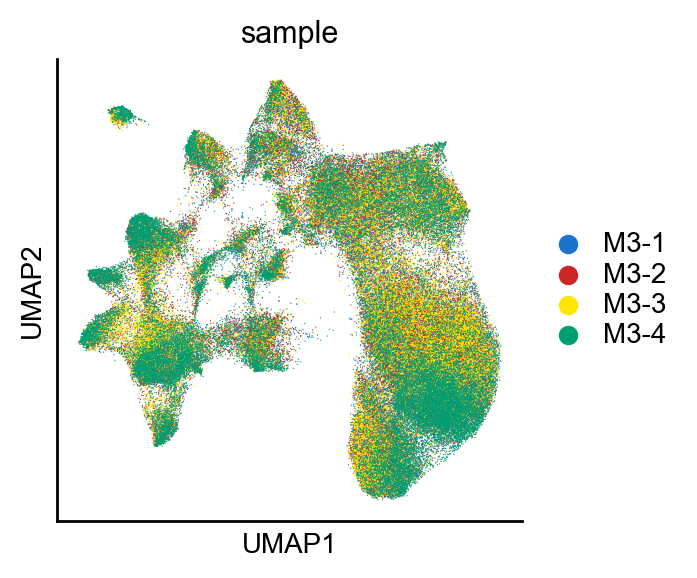

In [45]:
sc.pl.umap(adata, color=['sample'])

In [35]:
adata.obs['cell_subtype'] = adata.obs['resolvi_predicted']
col_exclude = ["keep", "predicted_celltype", "resolvi_predicted"]
col_exclude.extend([col for col in adata.obs if col.startswith('_')])
adata.obs.drop(columns=col_exclude, inplace=True)

## Cell type densities

In [ ]:
adata_list = []
radius = 100
for i in sample_names.values():
    adata_sample = adata[adata.obs['sample'] == i].copy()
    sq.gr.spatial_neighbors(adata_sample, radius= radius, coord_type = "generic")
    adata_sample.obs["total_density"] = (adata_sample.obsp["spatial_connectivities"].sum(
        axis=0) / (np.pi * (radius/1000)**2)).tolist()[0]
    subtype_densities = pd.DataFrame(index = adata_sample.obs_names)
    for j in adata_sample.obs.cell_subtype.cat.categories:
        is_subtype = adata_sample.obs["cell_subtype"].isin([j]).values
        subtype_densities[j] = (is_subtype @ adata_sample.obsp["spatial_connectivities"]) / (np.pi * (radius/1000)**2)
    adata_sample.obsm["subtype_density"] = subtype_densities
    adata_list.append(adata_sample)
adata = ad.concat(adata_list)

## Cell cycle phase

In [ ]:
g2m_genes = ["Cdca2", "Kif2c", "Ncapd2", "Nek2"]
s_genes = ["Dscc1", "Msh2", "Rad51", "Rpa2", "Ung"]
adata.X = adata.layers['scaled'].copy()
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes.values, g2m_genes=g2m_genes.values)
adata.obs["phase"] = adata.obs["phase"].map({"G1":"G0/G1","S":"S","G2M":"G2/M"})

## Hotspot analysis

Use malignant cells from M3-2 for training

In [ ]:
section_tdata = adata[adata.obs["sample"].isin(["M3-2"]) & adata.obs["cell_subtype"].isin(["Malignant"])].copy()
sc.pp.calculate_qc_metrics(section_tdata,percent_top = None,log1p = False,inplace = True,layer = "counts")
section_tdata = section_tdata[:,section_tdata.var["mean_counts"] > .1].copy()

Get local correlations

In [ ]:
hs = section_tdata.copy()
hs.X = hs.layers["counts"]
hs = hotspot.Hotspot(hs,latent_obsm_key="spatial", umi_counts_obs_key="total_counts",model = "normal")
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.loc[hs_results.C > 0.05].index
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

Get modules

In [ ]:
modules = hs.create_modules(min_gene_threshold=4, core_only=True, fdr_threshold=0.01)
hs.plot_local_correlations(vmax = 30)
modules.to_csv(results_path / "hotspot_modules.csv")
with open(results_path / "hotspot_linkage.npy", "wb") as f:
    np.save(f,hs.linkage)

Get module scores for all sections

In [ ]:
module_scores = []
for section in adata.obs["sample"].unique():
    section_tdata = adata[(adata.obs["sample"] == section) & adata.obs["cell_subtype"].isin(["Malignant"])].copy()
    hs = section_tdata.copy()
    hs.X = hs.layers["counts"]
    hs = hs[:,hs.X.sum(axis = 0) > 0].copy()
    section_modules = modules[modules.index.isin(hs.var_names)]
    hs = hotspot.Hotspot(hs,latent_obsm_key="spatial", umi_counts_obs_key="total_counts",model = "normal")
    hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
    hs.modules = section_modules
    module_scores.append(hs.calculate_module_scores())
module_scores = pd.concat(module_scores)
module_scores.columns = module_scores.columns.astype(str)
module = module_scores.idxmax(axis = 1).astype(str)
adata.obs["hotspot_module"] = module
adata.obsm["module_scores"] = module_scores.reindex(adata.obs_names)

## Save data

In [ ]:
del adata.uns
del adata.obsm['X_spatial']
del adata.obsm['index_neighbor']
del adata.obsm['distance_neighbor']
adata.write(data_path / "M3.h5ad")